In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import optuna
import json
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.regularizers import L1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, make_scorer,accuracy_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Activation
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

# where you save the data 
path = '../Data/BTC/'


In [67]:
def read_json_file(variable_name): 
    # Open the JSON file and read its content
    with open(path + variable_name + '.json', 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data[variable_name])
    df['x'] = df['x'].astype(int)
    df['date'] = pd.to_datetime(df['x'], unit='ms')
    df[variable_name] = df['y']
    df = df.drop(['x','y'], axis=1)
    return df


In [81]:
def calculate_weekly_average(df): 
    df.set_index('date', inplace=True)
    # Group by month and calculate the average trade volume
    monthly_avg_df = df.resample('W').mean()
    # Reset the index to have 'date' as a column again
    monthly_avg_df.reset_index(inplace=True)
    # Display the resulting DataFrame
    return monthly_avg_df

In [82]:
def create_df_from_column_names(first_column, names): 
    df = calculate_weekly_average(read_json_file(first_column))
    for i in names: 
        price = calculate_weekly_average(read_json_file(i))
        df = df.merge(price, on='date')
    return df


# Data Preprocessing 

In [139]:
columns = ['difficulty', 'n-unique-addresses', 'trade-volume', 'n-transactions-total', 'cost-per-transaction', 
            'n-transactions-excluding-popular', 'avg-confirmation-time', 'estimated-transaction-volume-usd']
df = create_df_from_column_names('market-price', columns)
# drop row where the price is 0 
df = df[df['market-price'] != 0]
df.reset_index(inplace=True)

# calculate the return 
df['return'] = df['market-price'].diff() / df['market-price']
df['return'] = df['return'].shift(-1)
df = df.drop(['market-price','index'], axis=1)
df = df.dropna()



In [146]:
correlation_matrix = df.corr()
#  Exclude diagonal elements
correlation_matrix_no_diagonal = correlation_matrix.mask(
    pd.DataFrame(np.eye(len(correlation_matrix), dtype=bool), correlation_matrix.index, correlation_matrix.columns))

# Check for high absolute correlation coefficients
threshold = 0.8 
highly_correlated_pairs = []

for i in range(len(correlation_matrix_no_diagonal.columns)):
    for j in range(i):
        correlation = correlation_matrix_no_diagonal.iloc[i, j]
        if abs(correlation) > threshold:
            pair = (correlation_matrix_no_diagonal.columns[i], correlation_matrix_no_diagonal.index[j], correlation)
            highly_correlated_pairs.append(pair)

if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")


Highly correlated pairs:
n-transactions-total and difficulty: 0.9163368457473159


/var/folders/df/x7ngsr_15bx8pln6jsqgdxy00000gn/T/ipykernel_34949/1777331240.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


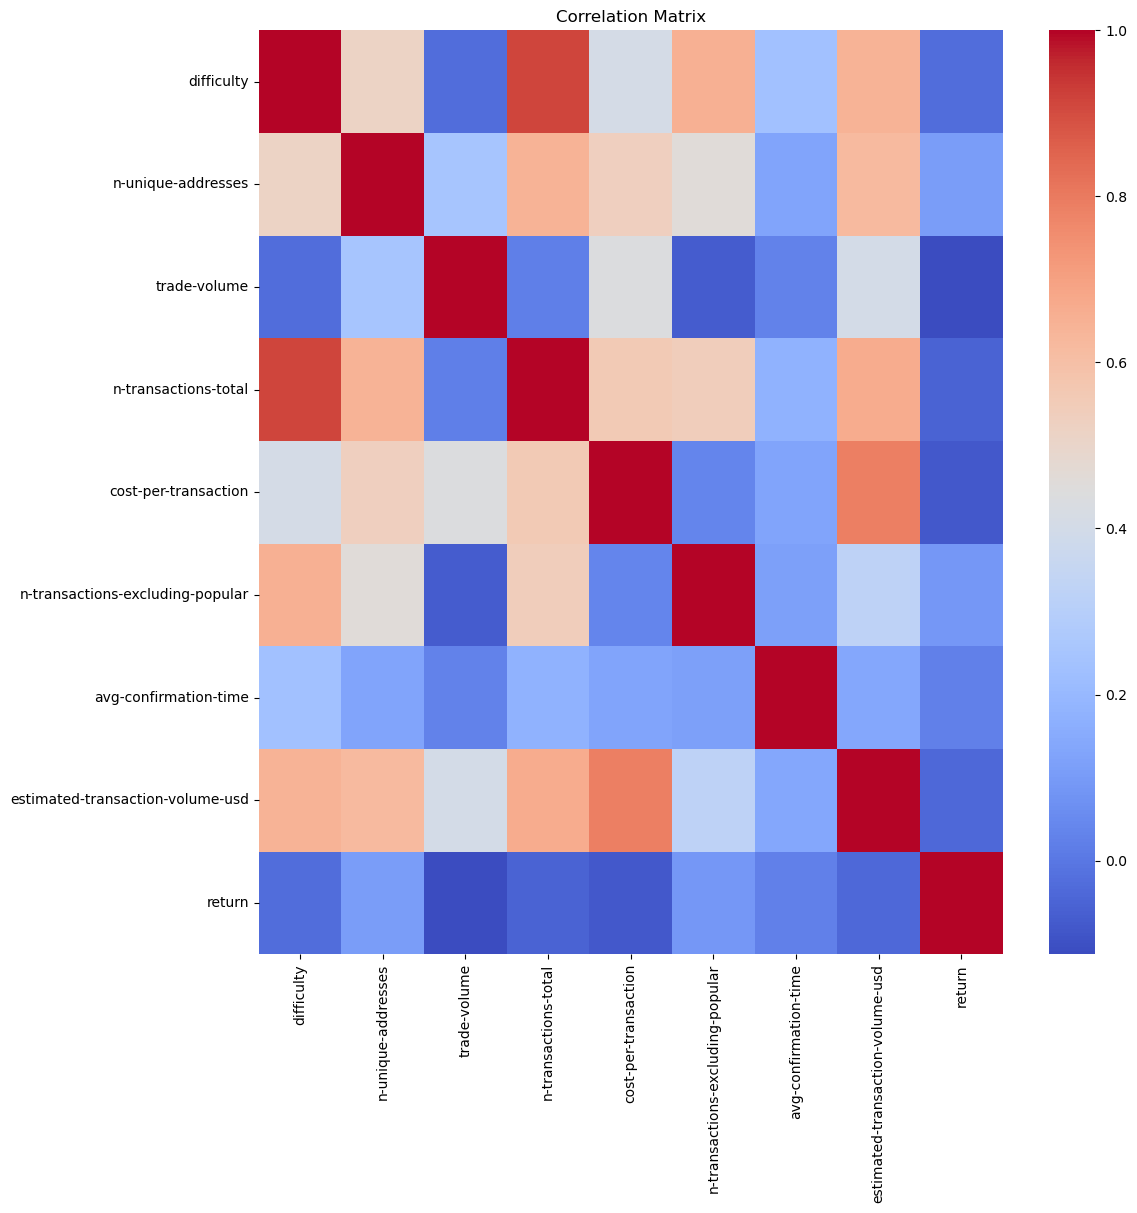

In [147]:
# Plot correlation matrix

plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



In [148]:
X = df.drop(columns=['return','date']) # everything except return info and IDs
y = df['return'] 

# make 20 years of training data
date = df['date']
training = (date <= '2020-03') # selects 
X_train, y_train = X.loc[training].values, y.loc[training].values 

# make 10 years of validation data
validation = (date > '2020-03') & (date <= '2022-03') 
X_val, y_val = X.loc[validation].values, y.loc[validation].values 

# make test data
test = (date > '2022-03') 
X_test, y_test = X.loc[test].values, y.loc[test].values 

print(X_train.shape,X_val.shape,X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
validate_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)



(202, 8) (104, 8) (114, 8)


In [98]:
# create the final model 
def create_nn(n_layers, input_dim, lamda, learning_rate):
    
    # max nodes in first layer 
    num_layers = 32 
    optimizer = Adam(learning_rate=learning_rate)

    # init model 
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, 
                kernel_regularizer=regularizers.L1(lamda), 
                kernel_initializer = 'he_normal'))
    model.add(BatchNormalization())

    # add extra hidden layers 
    for i in range(n_layers - 1): 
        num_layers = int(num_layers / 2)
        model.add(Dense(num_layers,
                kernel_regularizer=regularizers.L1(lamda), 
                kernel_initializer = 'he_normal'))
        model.add(BatchNormalization())
        
    # output layer 
    model.add(Dense(1, activation='linear',
                    kernel_regularizer=regularizers.L1(lamda), 
                    kernel_initializer = 'he_normal'))

    model.compile(loss='mse', 
                optimizer=optimizer,
                metrics = ['mse']) 
    return model 

In [149]:
lamda = 1e-05
epochs = 100
learning_rate = 0.001
patience = 5
batch_size = 10000
# model = create_nn(3, X_test.shape[1], lamda , learning_rate)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_dataset, 
                        epochs=100, 
                        # batch_size=batch_size, 
                        verbose=True,
                        validation_data = validate_dataset,
                        callbacks = [EarlyStopping(patience = patience, restore_best_weights=True)])
predictions = model.predict(X_test)
# df_predictions = pd.DataFrame(predictions, columns=['Prediction'])

Epoch 1/100


/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [150]:
# Evaluate the model
# print("Recall : " , recall_score(y_test, predictions))
# print("Precision : " , precision_score(y_test, predictions))
# predictions
print("Accuracy : " , mean_squared_error(y_test, predictions))

Accuracy :  0.9996744314651413
